<a href="https://colab.research.google.com/github/depresssed-kid/delivery-time/blob/main/delivery_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip uninstall -y scikit-learn
#!pip install scikit-learn==1.3.1

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing  import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import seaborn as sns
import xgboost as xg
import numpy as np
import scipy.stats as stats

In [3]:
time = pd.read_csv('Food_Delivery_Times.csv')
time.pop('Order_ID')
time.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [4]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Distance_km             1000 non-null   float64
 1   Weather                 970 non-null    object 
 2   Traffic_Level           970 non-null    object 
 3   Time_of_Day             970 non-null    object 
 4   Vehicle_Type            1000 non-null   object 
 5   Preparation_Time_min    1000 non-null   int64  
 6   Courier_Experience_yrs  970 non-null    float64
 7   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 62.6+ KB


In [5]:
time.isna().sum()

,0
Distance_km,0
Weather,30
Traffic_Level,30
Time_of_Day,30
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,30
Delivery_Time_min,0


In [6]:
time['Weather'] = time['Weather'].fillna(time['Weather'].mode()[0])
time['Traffic_Level'] = time['Traffic_Level'].fillna(time['Traffic_Level'].mode()[0])
time['Time_of_Day'] = time['Time_of_Day'].fillna(time['Time_of_Day'].mode()[0])
time['Courier_Experience_yrs'] = time['Courier_Experience_yrs'].fillna(time['Courier_Experience_yrs'].median())
time.isna().sum()

,0
Distance_km,0
Weather,0
Traffic_Level,0
Time_of_Day,0
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,0
Delivery_Time_min,0


array([[<Axes: title={'center': 'Distance_km'}>,
        <Axes: title={'center': 'Preparation_Time_min'}>],
       [<Axes: title={'center': 'Courier_Experience_yrs'}>,
        <Axes: title={'center': 'Delivery_Time_min'}>]], dtype=object)

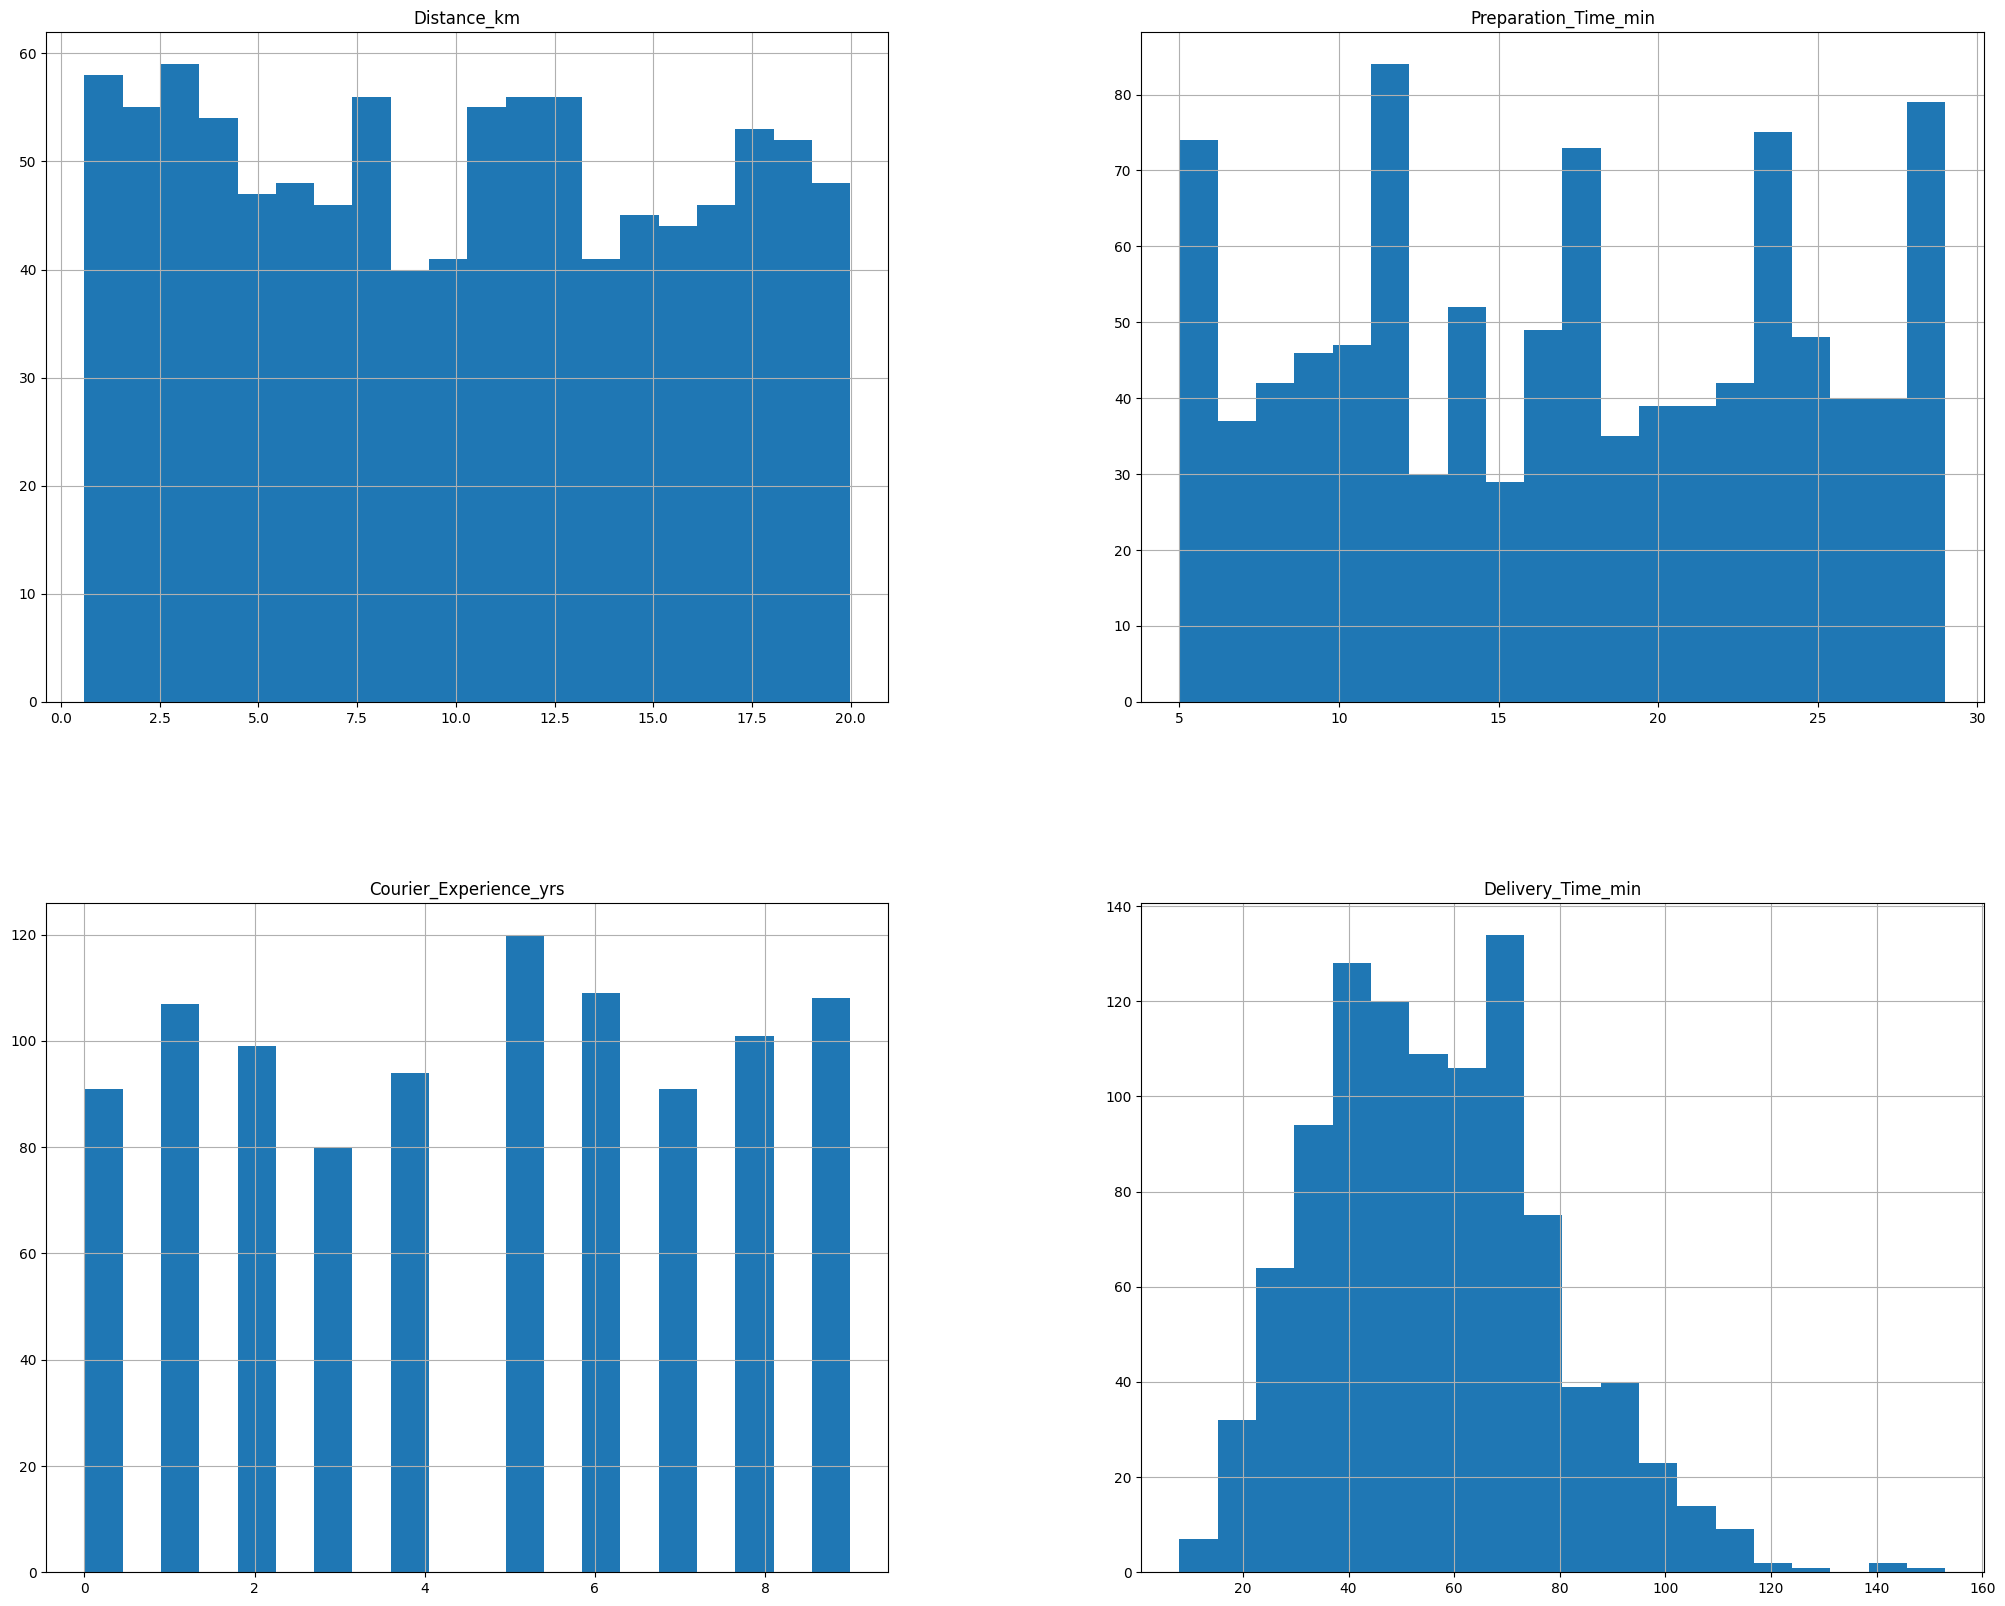

In [7]:
time.hist(bins=20, figsize=(25, 20))

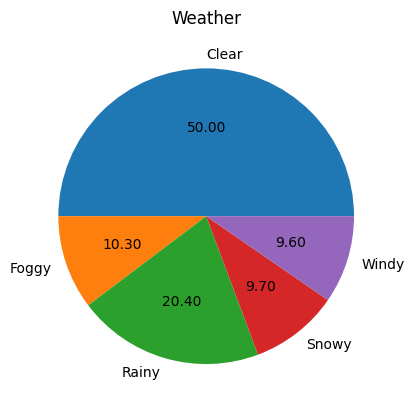

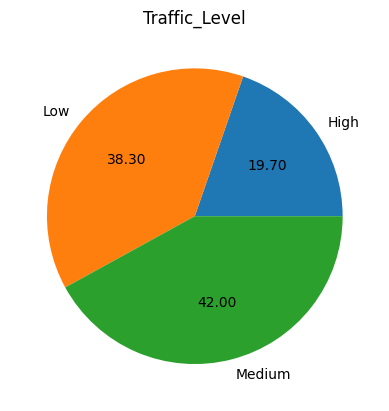

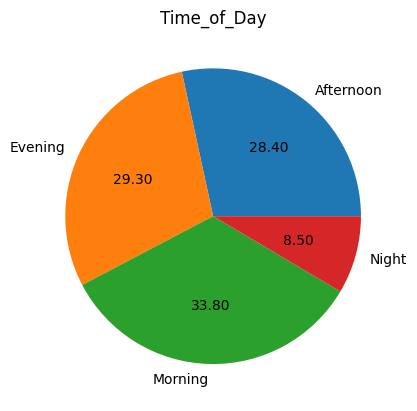

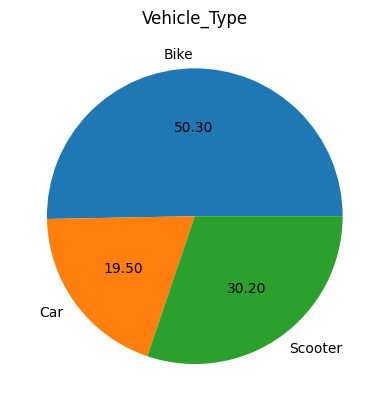

In [8]:
cat_cols = ['Weather','Traffic_Level','Time_of_Day','Vehicle_Type']
for col in cat_cols:
  plt.title(col)
  time.groupby(col).size().plot(kind='pie', autopct='%.2f')
  plt.show()


In [9]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
for col in time.columns.drop(cat_cols).drop('Delivery_Time_min'):
  time[col] = normalize([time[col]])[0]

time.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,0.021694,Windy,Low,Afternoon,Scooter,0.020573,0.005840,43
1,0.044919,Clear,Medium,Evening,Bike,0.034288,0.011680,84
2,0.026043,Foggy,Low,Night,Scooter,0.048003,0.005840,59
3,0.020353,Rainy,Medium,Afternoon,Scooter,0.008572,0.005840,37
4,0.052059,Clear,Low,Morning,Bike,0.027430,0.029199,68


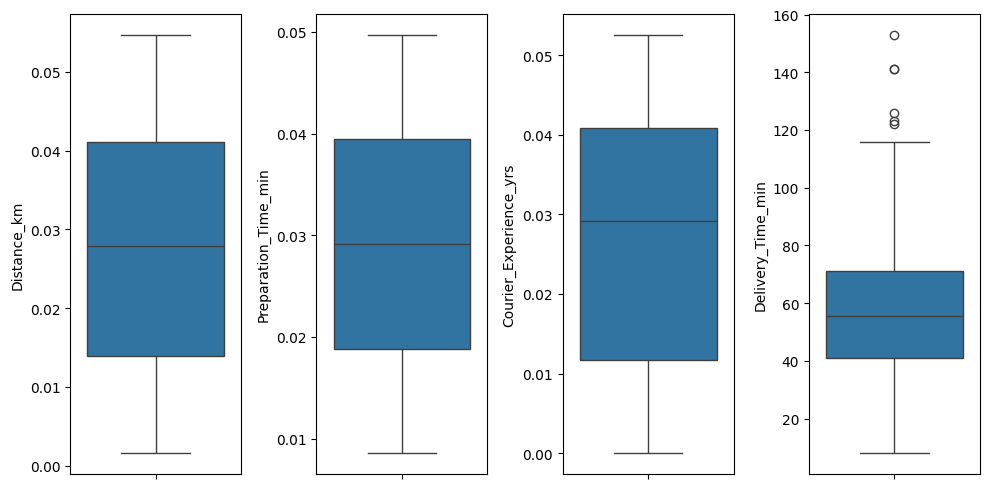

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs = axs.flatten()
for i, col in enumerate(time.columns.drop(cat_cols)):
    sns.boxplot( y=time[col], data=time, ax=axs[i])
plt.tight_layout()
plt.show()

гистограмма и ящик с усами 'Delivery_Time_min' показывают асимметрию

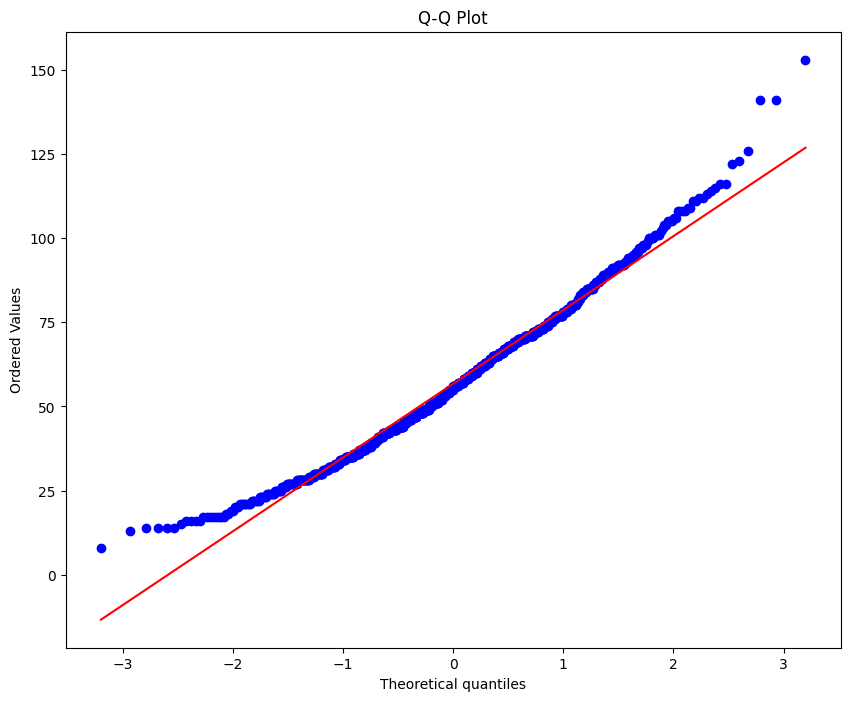

In [11]:
plt.figure(figsize=(10,8))
stats.probplot(time['Delivery_Time_min'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [12]:
shapiro_test = stats.shapiro(time['Delivery_Time_min'])
#Shapiro-Wilk Test
print("P-value:", shapiro_test.pvalue)

P-value: 1.1098038456872797e-09


полученные результаты позволяют  отвергнуть гипотезу о нормальности распределения

In [13]:
time['Delivery_Time_min'] = np.log(time['Delivery_Time_min'])

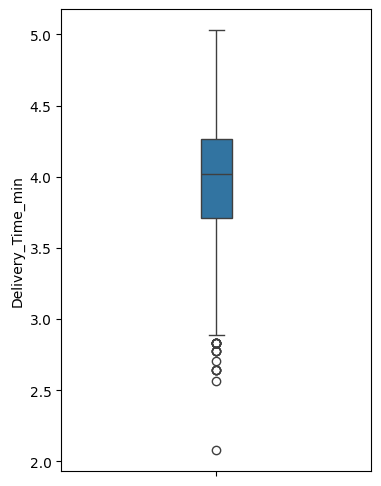

In [14]:
plt.figure(figsize=(4,6))
sns.boxplot( y=time['Delivery_Time_min'], data=time, width=0.1)
plt.show()

In [15]:
traff = ['Low', 'Medium','High']
traff_ordin_enc = OrdinalEncoder(categories=[traff])
time['Traffic_Level'] = traff_ordin_enc.fit_transform(time[['Traffic_Level']])
time.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,0.021694,Windy,0.0,Afternoon,Scooter,0.020573,0.005840,3.761200
1,0.044919,Clear,1.0,Evening,Bike,0.034288,0.011680,4.430817
2,0.026043,Foggy,0.0,Night,Scooter,0.048003,0.005840,4.077537
3,0.020353,Rainy,1.0,Afternoon,Scooter,0.008572,0.005840,3.610918
4,0.052059,Clear,0.0,Morning,Bike,0.027430,0.029199,4.219508


In [16]:
time = pd.get_dummies(time, columns=['Weather',  'Vehicle_Type', 'Time_of_Day'], drop_first=True)
time.head()

,Distance_km,Traffic_Level,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Vehicle_Type_Car,Vehicle_Type_Scooter,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night
0,0.021694,0.0,0.020573,0.005840,3.761200,False,False,False,True,False,True,False,False,False
1,0.044919,1.0,0.034288,0.011680,4.430817,False,False,False,False,False,False,True,False,False
2,0.026043,0.0,0.048003,0.005840,4.077537,True,False,False,False,False,True,False,False,True
3,0.020353,1.0,0.008572,0.005840,3.610918,False,True,False,False,False,True,False,False,False
4,0.052059,0.0,0.027430,0.029199,4.219508,False,False,False,False,False,False,False,True,False


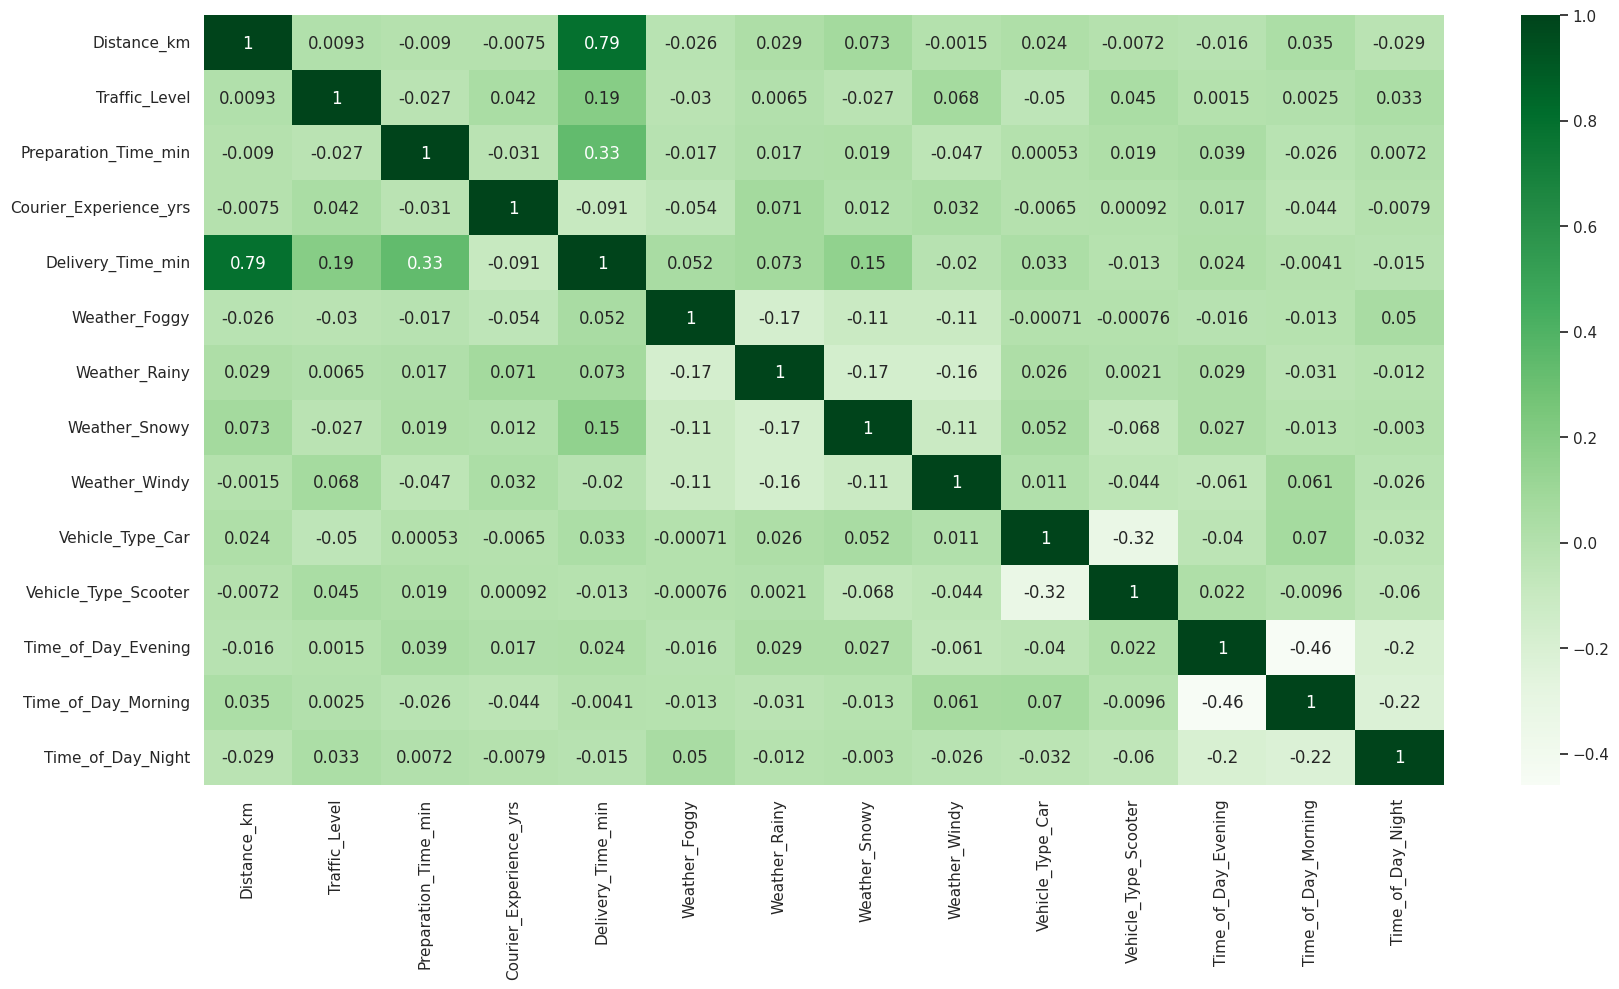

In [23]:
correlation_matrix = time.corr()
sns.heatmap(correlation_matrix,
            xticklabels=correlation_matrix.columns.values,
            yticklabels=correlation_matrix.columns.values,  cmap="Greens", annot=True)
sns.set(rc={"figure.figsize": (20, 10)})
plt.show()
#почему-то нужно запустить еще  раз чтобы нормальный размер выводился

In [18]:
X = time.drop('Delivery_Time_min', axis=1)
y = time['Delivery_Time_min']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
len(X_train), len(y_train)

(800, 800)

In [20]:
reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)
print('linear regression')
print('MAE:', mean_absolute_error(np.exp(y_test),np.exp(reg_pred)))
print('R^2:', r2_score(np.exp(y_test), np.exp(reg_pred)))

linear regression
MAE: 6.459369411206886
R^2: 0.7887011844758376


In [21]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [0, 0.5]
}
xgb = xg.XGBRegressor(objective='reg:squarederror',)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid)
grid_search.fit(X_train,y_train)

print("best parameters:", grid_search.best_params_)

best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 0.5}


In [22]:
xgb_r = xg.XGBRegressor(**grid_search.best_params_)
xgb_r.fit(X_train,y_train)
xgb_r_pred = xgb_r.predict(X_test)
print('xgboost')
print('MAE:', mean_absolute_error(np.exp(y_test),np.exp(xgb_r_pred)))
print('R^2:', r2_score(np.exp(y_test), np.exp(xgb_r_pred)))

xgboost
MAE: 6.19153434753418
R^2: 0.8149965649559531
